In [1]:
import torch, torchvision
import torch.nn.functional as F
from torchvision import transforms
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import random

In [2]:
class AdversarialNoise:

    def __init__(self, classToNum, imageSize = 256, device = 'cpu'):
        self.classToNum = classToNum
        self.numToClass = {self.classToNum[key] : key for key in self.classToNum}
        self.imageSize = imageSize
        self.loader = transforms.Compose([
            transforms.Resize(imageSize),
            transforms.ToTensor()
        ])
        self.device = device

    def classify(self, image, model):
        probs = torch.softmax(model(image).squeeze(),0)
        maxProbIdx = torch.argmax(probs).item()
        return self.numToClass[maxProbIdx], probs[maxProbIdx]

    def transform(self, image, newLabel, model, minSNRdB = 9, method = 'FGSM', maxIter = 20):
        if method == 'FGSM':
            return self._transformFGSM(image, newLabel, model, minSNRdB, maxIter)
        elif method == 'patch':
            return self._transformPatch(image, newLabel, model, minSNRdB, maxIter)

    def _transformFGSM(self, image, newLabel, model, minSNRdB = 9, maxIter = 20):
        '''
        Inspired bh the (iterative) FGSM attacks 
        [https://arxiv.org/pdf/1412.6572.pdf][https://arxiv.org/pdf/1607.02533.pdf]
        '''
        signalDB  = 20 * 2 * torch.log10(torch.linalg.norm(image))
        if minSNRdB > signalDB:
            print(f'The signal power is {signalDB} dB. Please, reduce the required SNR')
        
        noiseBaseDB = 20 * math.log10(image.nelement())
        eps = (1 / maxIter) * 10 ** ((signalDB - noiseBaseDB - minSNRdB) / 20)
        
        newLabelIdx = torch.LongTensor([adversarialNoise.classToNum[newLabel]])
        perturbedImage = torch.clone(image).detach().to(self.device)
        perturbedImage.requires_grad = True

        for _ in range(maxIter):
            perturbedImage.grad = None
            loss = - F.cross_entropy(model(perturbedImage), newLabelIdx)
            grad = torch.autograd.grad(loss, perturbedImage, retain_graph = False, create_graph = False)[0]
            perturbedImage = perturbedImage + eps * grad.sign()
            perturbedImage = torch.clamp(perturbedImage, 0, 1)

        return perturbedImage.detach()
        
    def _transformPatch(self, image, newLabel, model, minSNRdB = 9, maxIter = 20):
        '''
        Inspired by the Patch attack
        [https://arxiv.org/pdf/1712.09665.pdf]
        '''
        signalDB  = 20 * 2 * torch.log10(torch.linalg.norm(image))
        if minSNRdB > signalDB:
            print(f'The signal power is {signalDB} dB. Please, reduce the required SNR')

        maxNoisePower = 10 ** ((signalDB - minSNRdB) / 20)
        maxNoisePixels = maxNoisePower / 3
        width = height = math.floor(math.sqrt(maxNoisePixels))
            
        newLabelIdx = torch.LongTensor([adversarialNoise.classToNum[newLabel]])
        mask = torch.zeros(1, 1, image.shape[2], image.shape[3]).to(self.device)
        patch = torch.rand_like(image).to(self.device)
        mask[:, :, :width, :height] = 1
        patch.requires_grad = True
        mask.requires_grad = False

        for _ in range(maxIter):
            patch.grad = None
            perturbedImage = mask * patch + (1.0 - mask) * image
            loss = F.cross_entropy(model(perturbedImage), newLabelIdx)
            grad = torch.autograd.grad(loss, patch, retain_graph = False, create_graph = False)[0]
            patch = patch - mask * grad
            patch = torch.clamp(patch, 0, 1)

        return mask * patch.detach() + (1.0 - mask) * image


    def loadImage(self, imagePath):
        image = PIL.Image.open(imagePath)
        image = self.loader(image).float()
        image = image.unsqueeze(0)
        return image.to(self.device)

# Example of model initialization

In [3]:
with open('classToNum.pkl', 'rb') as file:
    classToNum = pickle.load(file)

adversarialNoise = AdversarialNoise(classToNum)

# Examples of model fooling - ResNet 50 on Imagenet

In [4]:
def displayImage(tensor, prediction, probability):
    figure = plt.figure()
    plt.imshow(tensor.squeeze(0).permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Classified as {prediction[:11]} with {100*probability:.2f}% confidence')
    plt.show()

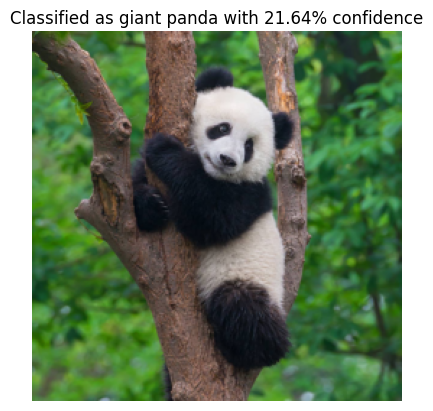

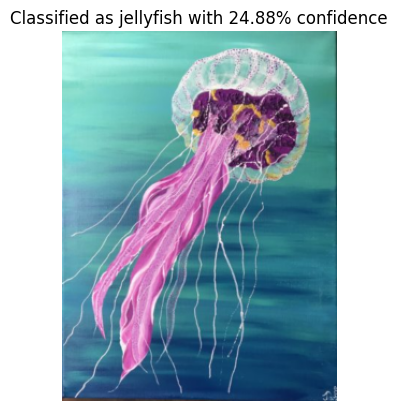

In [5]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
model.eval()
pandaImage = adversarialNoise.loadImage('imagenet_data/panda.jpeg')
jellyfishImage = adversarialNoise.loadImage('imagenet_data/jellyfish.jpeg')
pandaImageClassification, pandaImageProbability = adversarialNoise.classify(pandaImage, model)
jellyfishImageClassification, jellyfishImageProbability = adversarialNoise.classify(jellyfishImage, model)
displayImage(pandaImage, pandaImageClassification, pandaImageProbability)
displayImage(jellyfishImage, jellyfishImageClassification, jellyfishImageProbability)

## Fooling with the FGSM algorithm (9dB)

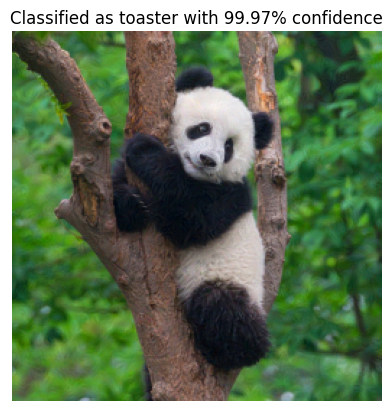

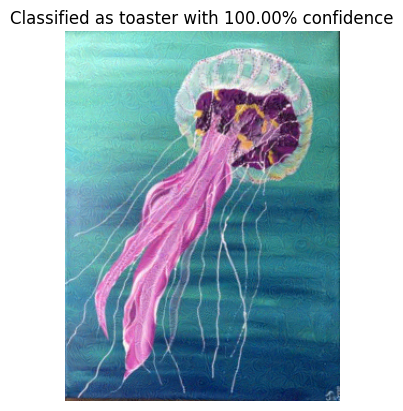

In [6]:
newLabel = 'toaster'
perturbedPandaImage = adversarialNoise.transform(pandaImage, newLabel, model)
perturbedJellyfishImage = adversarialNoise.transform(jellyfishImage, newLabel, model)
perturbedPandaImageClassification, perturbedPandaImageProbability = adversarialNoise.classify(perturbedPandaImage, model)
perturbedJellyfishImageClassification, perturbedJellyfishImageProbability = adversarialNoise.classify(perturbedJellyfishImage, model)
displayImage(perturbedPandaImage, perturbedPandaImageClassification, perturbedPandaImageProbability)
displayImage(perturbedJellyfishImage, perturbedJellyfishImageClassification, perturbedJellyfishImageProbability)

## Fooling with a patch (9 and 12 dBs)

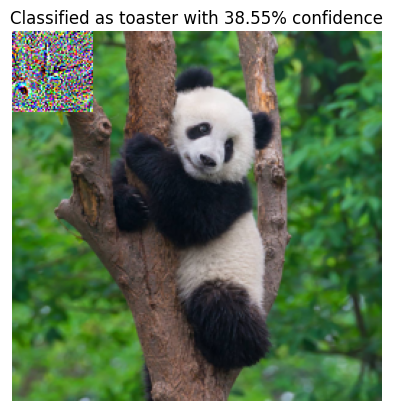

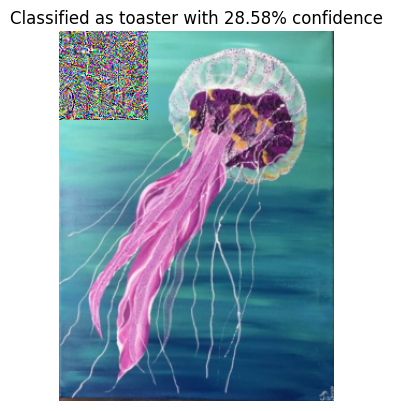

In [7]:
newLabel = 'toaster'
perturbedPandaImage = adversarialNoise.transform(pandaImage, newLabel, model, method = 'patch', minSNRdB = 9, maxIter = 200)
perturbedJellyfishImage = adversarialNoise.transform(jellyfishImage, newLabel, model, method = 'patch', minSNRdB = 12, maxIter = 200)
perturbedPandaImageClassification, perturbedPandaImageProbability = adversarialNoise.classify(perturbedPandaImage, model)
perturbedJellyfishImageClassification, perturbedJellyfishImageProbability = adversarialNoise.classify(perturbedJellyfishImage, model)
displayImage(perturbedPandaImage, perturbedPandaImageClassification, perturbedPandaImageProbability)
displayImage(perturbedJellyfishImage, perturbedJellyfishImageClassification, perturbedJellyfishImageProbability)